In [1]:

#Run this once, to create a file with 1st 11 rows from training file
#!head -n 11 idc_train.csv > idc_train.small.csv
#!wc -l idc_train.small.csv
from pyspark.sql import SparkSession, SQLContext
from pyspark import SparkConf, SparkContext
conf = SparkConf()
conf.set("spark.executor.memory", "10g")
conf.set("spark.driver.memory", "10g")
spark_context = SparkContext.getOrCreate(conf)
spark = SparkSession(spark_context)

VBox()

Starting Spark application


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
import timeit
start = timeit.default_timer()
stop =timeit.default_timer()
print('time:',stop-start)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

time: 3.69109998246131e-05

In [3]:

sc.install_pypi_package("matplotlib")
sc.install_pypi_package("plotly.express")
sc.install_pypi_package("sklearn")
sc.install_pypi_package("pandas==0.25.1")
sc.install_pypi_package("nominatim")
sc.install_pypi_package("geopy")
sc.install_pypi_package("seaborn")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/24/33/5568d443ba438d95d4db635dd69958056f087e57e1026bee56f959d53f9d/matplotlib-3.4.2-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/8a/bb/488841f56197b13700afd5658fc279a2025a39e22449b7cf29864669b15d/pyparsing-2.4.7-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/8e/7a/b047f6f80fdb02c0cca1d3761d71e9800bcf6d4874b71c9e6548ec59e156/Pillow-8.3.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/d2/46/231de802ade4225b76b96cffe419cf3ce52bbe92e3b092cf12db7d11c207/kiwisolver-1.3.1-cp37-cp37m-manylinux1_x86_64.whl

  Using cached https://files.pythonhosted.org/packages/d4/d6/8a2906f51e073a4be80cab35cfa10e7a34853e60f3ed5304ac470852a08d/plotly_express-0.4.1-py2.py3

In [4]:
import numpy as np
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType, IntegerType, StringType, FloatType, ByteType, DateType, TimestampType
from pyspark.sql import SparkSession, SQLContext
from pyspark import SparkConf, SparkContext
from pyspark.sql.functions import to_date, dayofweek, hour
from  pyspark.sql.functions import avg, col 
import  pyspark.sql.functions as f
from  pyspark.sql.functions import avg, col,stddev
import random
import matplotlib
import matplotlib.pyplot as plt
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
import pandas as pd
from sklearn.metrics import confusion_matrix


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Importing the data

In [5]:
start = timeit.default_timer()


conf = SparkConf()
conf.set("spark.executor.memory", "24g")
conf.set("spark.driver.memory", "24g")
conf.set("spark.sql.session.timeZone", "UTC")
conf.set("spark.driver.maxResultSize", "4g")
spark_context = SparkContext.getOrCreate(conf)
spark = SparkSession(spark_context)
sc = spark.sparkContext
sqlContext = SQLContext(sc)

train = "/user/hadoop/idc_train.csv"
test = "/user/hadoop/idc_test.csv"


schema = StructType([
    StructField("key", IntegerType()),
    StructField("fare_amount", FloatType()),
    StructField("pickup_datetime", TimestampType()),
    StructField("pickup_longitude", FloatType()),
    StructField("pickup_latitude", FloatType()),
    StructField("dropoff_longitude", FloatType()),
    StructField("dropoff_latitude", FloatType()),
    StructField("passenger_count", FloatType())
])

X_train = spark.read.format("csv").option("header",
                                          "true").schema(schema).option(
                                              "TimeStampFormat",
                                              "yyyy-mm-dd hh:mm:ss").load(train)


stop =timeit.default_timer()
print('time:',stop-start)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

time: 2.825309737000225

In [7]:
start = timeit.default_timer()
small_train = X_train.withColumn("high_fare", (X_train.fare_amount>=10).cast("Byte"))
small_train.show(truncate=False)
small_train.count(),len(small_train.columns)
stop =timeit.default_timer()
print('time:',stop-start)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+---------+
|key|fare_amount|pickup_datetime    |pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|high_fare|
+---+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+---------+
|1  |8.5        |2010-03-30 19:27:00|-73.96539       |40.768574      |-73.998184       |40.761074       |1.0            |0        |
|7  |7.5        |2013-04-21 22:33:38|-73.964645      |40.760117      |-73.98311        |40.734978       |1.0            |0        |
|17 |7.7        |2012-09-03 01:39:17|-73.996216      |40.742603      |-73.9973         |40.763718       |1.0            |0        |
|24 |4.5        |2010-08-09 07:49:00|-73.98238       |40.764503      |-73.98455        |40.755737       |1.0            |0        |
|46 |3.3        |2012-02-23 12:05:00|-73.96727       |40.769         |-73.96

## Removing empty rows 

In [8]:
small_train_na=small_train.dropna()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Data cleaning


In [9]:
start = timeit.default_timer()
correctNegativeDiff = f.udf(lambda diff : None if diff <= 0.0 else diff, DoubleType())
df = small_train_na.withColumn('fare_amount', correctNegativeDiff(small_train_na.fare_amount))
df = df.na.fill(value = int(small_train_na.agg(avg(col("fare_amount"))).collect()[0][0]),subset=["fare_amount"])
stop =timeit.default_timer()
print('time:',stop-start)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

time: 99.04396487899976

In [10]:
start = timeit.default_timer()
correctNegativeDiff = f.udf(lambda diff : None if diff < 0 else diff, DoubleType())
df = df.withColumn('passenger_count', correctNegativeDiff(df.passenger_count))

df = df.na.fill(value = int(df.agg(avg(col("passenger_count"))).collect()[0][0]),subset=["passenger_count"])
stop =timeit.default_timer()
print('time:',stop-start)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

time: 133.6514759370002

### Spliting the Timestemp

In [11]:
start = timeit.default_timer()
df1 = df.withColumn('day_of_week',dayofweek(df.pickup_datetime))
df1 = df1.withColumn('hour',f.hour(df1.pickup_datetime))
df1 = df1.withColumn('year',f.year(df1.pickup_datetime))
df1 = df1.withColumn('day_ofyear',f.dayofyear(df1.pickup_datetime))
stop =timeit.default_timer()
print('time:',stop-start)



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

time: 0.0700478419994397

In [12]:
df.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+------------------+-------------------+----------------+---------------+-----------------+----------------+---------------+---------+
|key|       fare_amount|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|high_fare|
+---+------------------+-------------------+----------------+---------------+-----------------+----------------+---------------+---------+
|  1|               8.5|2010-03-30 19:27:00|       -73.96539|      40.768574|       -73.998184|       40.761074|            1.0|        0|
|  7|               7.5|2013-04-21 22:33:38|      -73.964645|      40.760117|        -73.98311|       40.734978|            1.0|        0|
| 17| 7.699999809265137|2012-09-03 01:39:17|      -73.996216|      40.742603|         -73.9973|       40.763718|            1.0|        0|
| 24|               4.5|2010-08-09 07:49:00|       -73.98238|      40.764503|        -73.98455|       40.755737|            1.0|        0|
| 46| 3.299999952316284|201

## Removing outliers from the data


In [13]:
start = timeit.default_timer()

uper =  float(df1.agg(avg(col("pickup_longitude"))).collect()[0][0] + df1.agg(stddev(col("pickup_longitude"))).collect()[0][0])
lower = float(df1.agg(avg(col("pickup_longitude"))).collect()[0][0] - df1.agg(stddev(col("pickup_longitude"))).collect()[0][0])
print(lower,uper)
correctNegativeDiff = f.udf(lambda diff : None if diff < lower or diff > uper  else diff, DoubleType())
df2 = df1.withColumn('pickup_longitude', correctNegativeDiff(df.pickup_longitude))
df2 = df2.na.fill(value = int(df2.agg(avg(col("pickup_longitude"))).collect()[0][0]),subset=["pickup_longitude"])

stop =timeit.default_timer()
print('time:',stop-start)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-87.10636368706757 -57.953497274078074
time: 505.6509300029993

In [14]:
start = timeit.default_timer()

uper =  float(df1.agg(avg(col("pickup_latitude"))).collect()[0][0] + df1.agg(stddev(col("pickup_latitude"))).collect()[0][0])
lower = float(df1.agg(avg(col("pickup_latitude"))).collect()[0][0] - df1.agg(stddev(col("pickup_latitude"))).collect()[0][0])
print(lower,uper)
correctNegativeDiff = f.udf(lambda diff : None if diff < lower or diff > uper  else diff, DoubleType())
df2 = df2.withColumn('pickup_latitude', correctNegativeDiff(df.pickup_latitude))
df2 = df2.na.fill(value = int(df2.agg(avg(col("pickup_latitude"))).collect()[0][0]),subset=["pickup_latitude"])

stop =timeit.default_timer()
print('time:',stop-start)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

31.781657245256543 48.04587953372984
time: 501.65040328099985

In [15]:
start = timeit.default_timer()

uper =  float(df1.agg(avg(col("dropoff_longitude"))).collect()[0][0] + df1.agg(stddev(col("dropoff_longitude"))).collect()[0][0])
lower = float(df1.agg(avg(col("dropoff_longitude"))).collect()[0][0] - df1.agg(stddev(col("dropoff_longitude"))).collect()[0][0])
print(lower,uper)
correctNegativeDiff = f.udf(lambda diff : None if diff < lower or diff > uper  else diff, DoubleType())
df2 = df2.withColumn('dropoff_longitude', correctNegativeDiff(df.dropoff_longitude))
df2 = df2.na.fill(value = int(df2.agg(avg(col("dropoff_longitude"))).collect()[0][0]),subset=["dropoff_longitude"])

stop =timeit.default_timer()
print('time:',stop-start)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-85.8719946894955 -59.166466313539274
time: 493.0760695220006

In [16]:
start = timeit.default_timer()

uper =  float(df1.agg(avg(col("dropoff_latitude"))).collect()[0][0] + df1.agg(stddev(col("dropoff_latitude"))).collect()[0][0])
lower = float(df1.agg(avg(col("dropoff_latitude"))).collect()[0][0] - df1.agg(stddev(col("dropoff_latitude"))).collect()[0][0])
print(lower,uper)
correctNegativeDiff = f.udf(lambda diff : None if diff < lower or diff > uper  else diff, DoubleType())
df2 = df2.withColumn('dropoff_latitude', correctNegativeDiff(df.dropoff_latitude))
df2 = df2.na.fill(value = int(df2.agg(avg(col("dropoff_latitude"))).collect()[0][0]),subset=["dropoff_latitude"])

stop =timeit.default_timer()
print('time:',stop-start)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

30.55854527588418 49.28420643889751
time: 500.36333161899984

## Compute Distance 1 

In [17]:
start = timeit.default_timer()

df2 = df2.withColumn('distance', ((df2.pickup_longitude -df2.dropoff_longitude)**2 +(df2.pickup_latitude-df2.dropoff_latitude)**2)**0.5)

stop =timeit.default_timer()
print('time:',stop-start)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

time: 0.046671168000102625

## Compute Distanc 2

In [18]:
import  pyspark.sql.functions as F
start = timeit.default_timer()

df2= df2.withColumn("a", (
        F.pow(F.sin(F.radians(F.col("dropoff_latitude") - F.col("pickup_latitude")) / 2), 2) +
        F.cos(F.radians(F.col("pickup_latitude"))) * F.cos(F.radians(F.col("dropoff_latitude"))) *
        F.pow(F.sin(F.radians(F.col("dropoff_longitude") - F.col("pickup_longitude")) / 2), 2)
    )).withColumn("distance2", F.atan2(F.sqrt(F.col("a")), F.sqrt(-F.col("a") + 1)) * 12742000)

stop =timeit.default_timer()
print('time:',stop-start)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

time: 0.09895281199987949

In [19]:
df2.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+------------------+-------------------+------------------+------------------+------------------+------------------+---------------+---------+-----------+----+----+----------+--------------------+--------------------+------------------+
|key|       fare_amount|    pickup_datetime|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|passenger_count|high_fare|day_of_week|hour|year|day_ofyear|            distance|                   a|         distance2|
+---+------------------+-------------------+------------------+------------------+------------------+------------------+---------------+---------+-----------+----+----+----------+--------------------+--------------------+------------------+
|  1|               8.5|2010-03-30 19:27:00|-73.96539306640625| 40.76857376098633|-73.99818420410156| 40.76107406616211|            1.0|        0|          3|  19|2010|        89|0.033637837828988916|5.125692859682867E-8|2884.7879409444267|
|  7|               7.5|2013-04-21 2

### Plots

In [20]:
df_plots = df2.limit(10000)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
df3=df_plots.toPandas()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
sc.install_pypi_package("plotly")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…


You are using pip version 9.0.1, however version 21.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

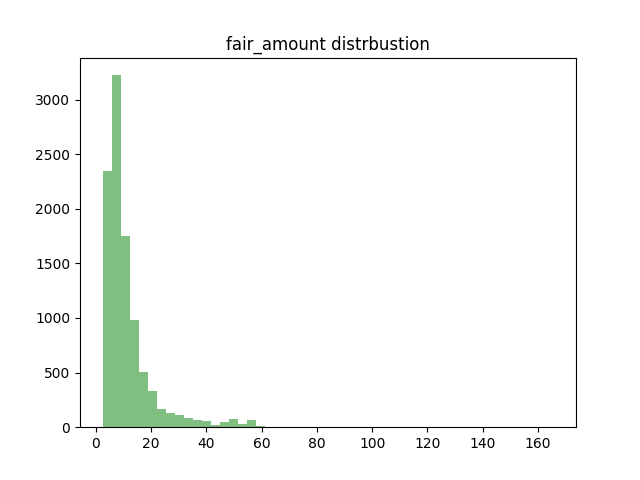

In [23]:
plt.clf()
import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pyplot as mplt
import plotly
import plotly.express as px

num_bins = 50
n, bins, patches = plt.hist(df3['fare_amount'], num_bins, facecolor='green', alpha=0.5)
plt.title("fair_amount distrbustion")
%matplot plt


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

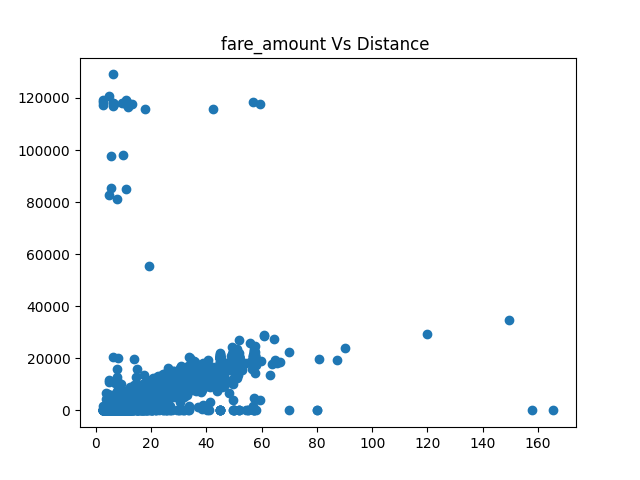

In [24]:
plt.clf()

plt.scatter(df3['fare_amount'], df3["distance2"])

plt.title("fare_amount Vs Distance ")
plt.show()
%matplot plt


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

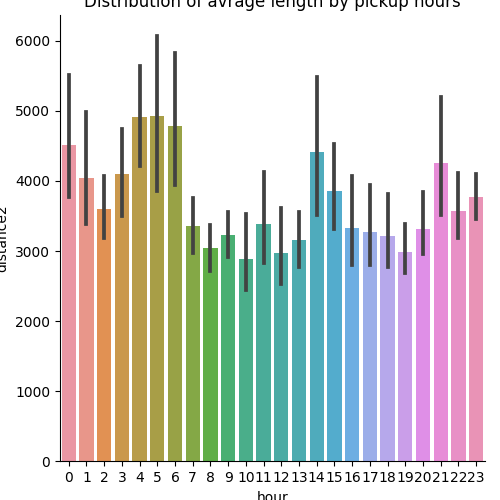

In [25]:
plt.clf()
import seaborn as sns

ax=sns.catplot(x="hour", y="distance2",kind="bar",data=df3).set(title='Distribution of avrage length by pickup hours')

plt.show()
%matplot plt


## preparing the Data from ML models 

In [26]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.linalg import Vectors

start = timeit.default_timer()


categoricalColumns = ["hour","year","day_ofyear","passenger_count"]
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCol=stringIndexer.getOutputCol(), outputCol=categoricalCol + "classVec")
    stages += [stringIndexer, encoder]
    
label_stringIdx = StringIndexer(inputCol = 'high_fare', outputCol = 'label')

stages += [label_stringIdx]

numericCols = ['distance', 'distance2']

assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols

assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

stages += [assembler]

stop =timeit.default_timer()
print('time:',stop-start)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

time: 0.07235412399950292

In [27]:
start = timeit.default_timer()

cols = df2.columns
pipeline = Pipeline(stages = stages) 
pipelineModel = pipeline.fit(df2)
df2 = pipelineModel.transform(df2)
selectedCols = ['label', 'features'] 
df2 = df2.select(selectedCols)
df2.printSchema()

stop =timeit.default_timer()
print('time:',stop-start)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)

time: 520.8161286909999

In [28]:
start = timeit.default_timer()

train_df, test_df = df2.randomSplit([0.8, 0.2], seed=1000)

stop =timeit.default_timer()
print('time:',stop-start)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

time: 0.009612127999389486

## LogisticRegression Model

In [29]:
start = timeit.default_timer()

from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train_df)

stop =timeit.default_timer()
print('time:',stop-start)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

time: 216.2857886440006

In [30]:
plt.clf()

trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
%matplot plt
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Training set areaUnderROC: 0.9176927348408405

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

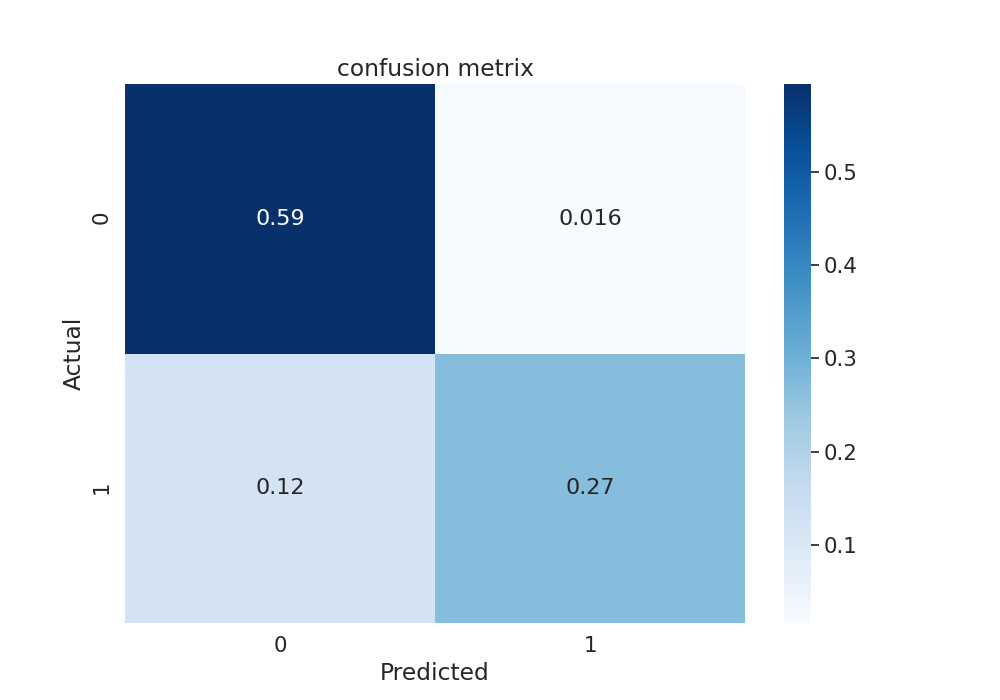

In [31]:
plt.clf()

y_true = test_df.toPandas()["label"].astype(int)
y_pred = lrModel.transform(test_df).toPandas()["prediction"].astype(int)

data = confusion_matrix(y_true, y_pred)/len(y_true)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})
plt.title("confusion metrix")
plt.show()
%matplot plt

In [32]:
predictions = lrModel.transform(test_df)
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test Area Under ROC 0.9181247011308468

## Desion Tree Model 

In [33]:
start = timeit.default_timer()

from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train_df)
predictions = dtModel.transform(test_df)

stop =timeit.default_timer()
print('time:',stop-start)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

time: 328.49399949599956

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

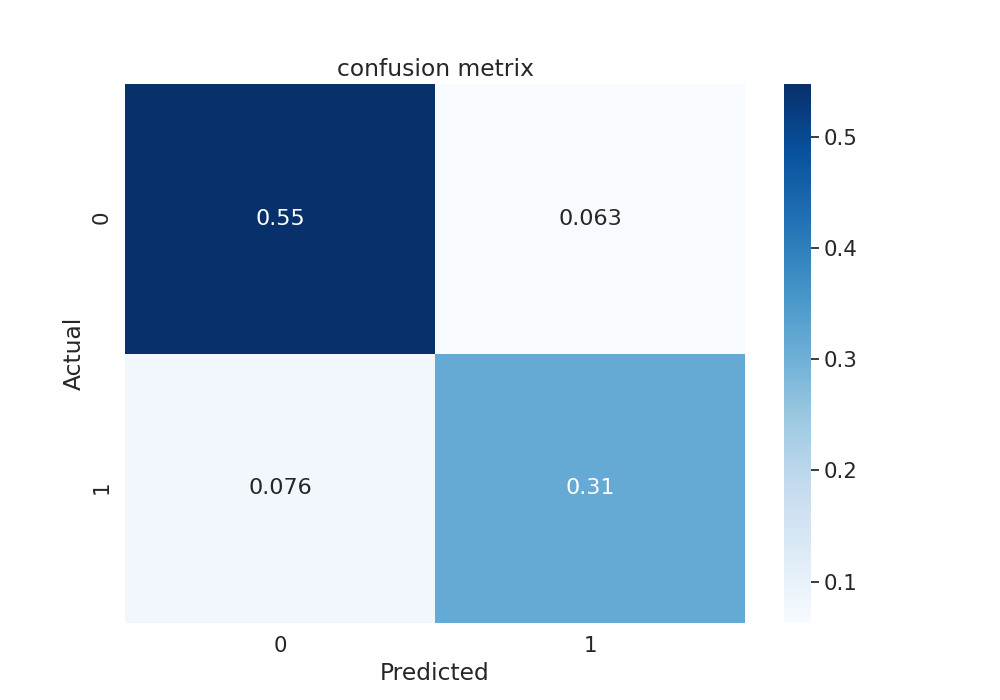

In [34]:
plt.clf()

y_true = test_df.toPandas()["label"].astype(int)
y_pred = dtModel.transform(test_df).toPandas()["prediction"].astype(int)

data = confusion_matrix(y_true, y_pred)/len(y_true)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})
plt.title("confusion metrix")
plt.show()
%matplot plt

In [35]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test Area Under ROC: 0.8116592185334964

### Random Forest Classifier


In [ ]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train_df)
predictions = rfModel.transform(test_df)
predictions.select('hour', 'year', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

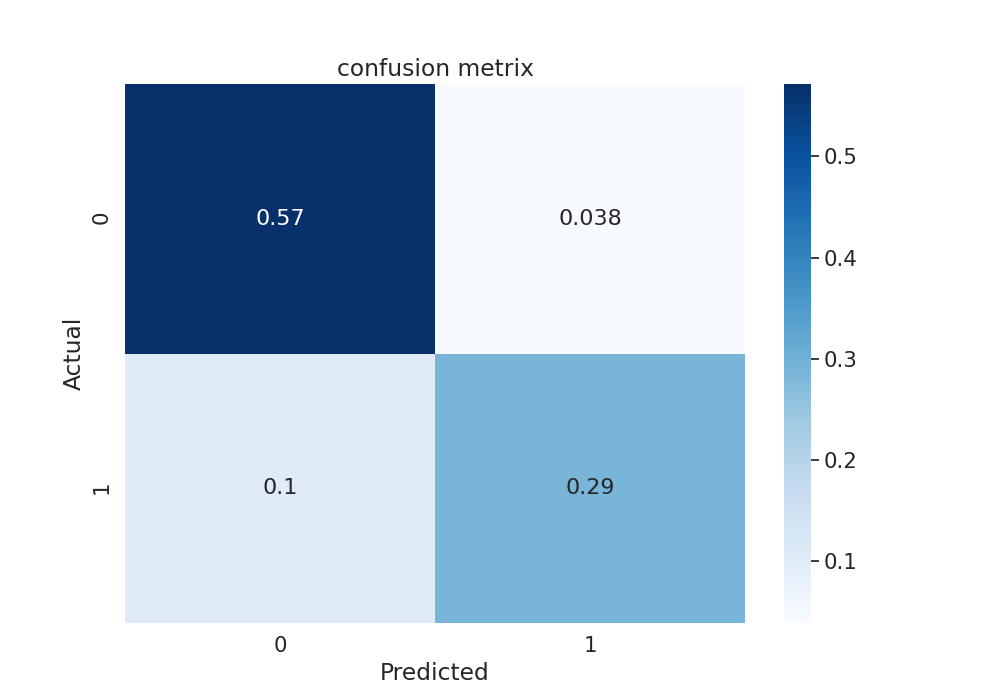

In [37]:
plt.clf()

y_true = test_df.toPandas()["label"].astype(int)
y_pred = rfModel.transform(test_df).toPandas()["prediction"].astype(int)

data = confusion_matrix(y_true, y_pred)/len(y_true)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})
plt.title("confusion metrix")
plt.show()
%matplot plt

In [38]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test Area Under ROC: 0.8902996364198702

### Gradient-Boosted Tree Classifier.

In [39]:
start = timeit.default_timer()

from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train_df)
predictions = gbtModel.transform(test_df)

stop =timeit.default_timer()
print('time:',stop-start)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

time: 444.72304093500134

In [40]:
from sklearn.metrics import confusion_matrix


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

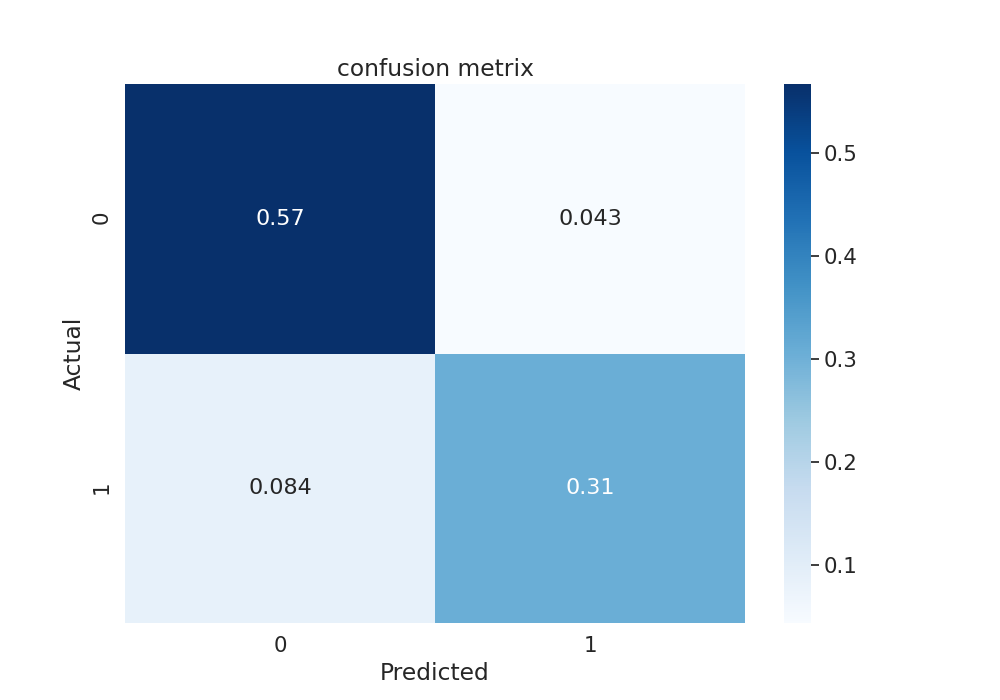

In [41]:
plt.clf()

y_true = test_df.toPandas()["label"].astype(int)
y_pred = gbtModel.transform(test_df).toPandas()["prediction"].astype(int)

data = confusion_matrix(y_true, y_pred)/len(y_true)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})
plt.title("confusion metrix")
plt.show()
%matplot plt

In [42]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test Area Under ROC: 0.9333111209196923

### cross validation


### Prep test Data


In [ ]:
schema = StructType([
    StructField("key", IntegerType()),
    StructField("pickup_datetime", TimestampType()), # Will later extract date and time
    StructField("pickup_longitude", FloatType()),
    StructField("pickup_latitude", FloatType()),
    StructField("dropoff_longitude", FloatType()),
    StructField("dropoff_latitude", FloatType()),
    StructField("passenger_count", FloatType())
])

X_test = spark.read.format("csv").option("header",
                                          "true").schema(schema).option(
                                              "TimeStampFormat",
                                              "yyyy-mm-dd hh:mm:ss").load(test) 

df = X_test
df1 = df.withColumn('day_of_week',dayofweek(df.pickup_datetime))
df1 = df1.withColumn('hour',f.hour(df1.pickup_datetime))
df1 = df1.withColumn('year',f.year(df1.pickup_datetime))
df1 = df1.withColumn('day_ofyear',f.dayofyear(df1.pickup_datetime))


uper =  float(df1.agg(avg(col("pickup_longitude"))).collect()[0][0] + df1.agg(stddev(col("pickup_longitude"))).collect()[0][0])
lower = float(df1.agg(avg(col("pickup_longitude"))).collect()[0][0] - df1.agg(stddev(col("pickup_longitude"))).collect()[0][0])
print(lower,uper)
correctNegativeDiff = f.udf(lambda diff : None if diff < lower or diff > uper  else diff, DoubleType())
df2 = df1.withColumn('pickup_longitude', correctNegativeDiff(df.pickup_longitude))
df2 = df2.na.fill(value = int(df2.agg(avg(col("pickup_longitude"))).collect()[0][0]),subset=["pickup_longitude"])

uper =  float(df1.agg(avg(col("pickup_latitude"))).collect()[0][0] + df1.agg(stddev(col("pickup_latitude"))).collect()[0][0])
lower = float(df1.agg(avg(col("pickup_latitude"))).collect()[0][0] - df1.agg(stddev(col("pickup_latitude"))).collect()[0][0])
print(lower,uper)
correctNegativeDiff = f.udf(lambda diff : None if diff < lower or diff > uper  else diff, DoubleType())
df2 = df2.withColumn('pickup_latitude', correctNegativeDiff(df.pickup_latitude))
df2 = df2.na.fill(value = int(df2.agg(avg(col("pickup_latitude"))).collect()[0][0]),subset=["pickup_latitude"])

uper =  float(df1.agg(avg(col("dropoff_longitude"))).collect()[0][0] + df1.agg(stddev(col("dropoff_longitude"))).collect()[0][0])
lower = float(df1.agg(avg(col("dropoff_longitude"))).collect()[0][0] - df1.agg(stddev(col("dropoff_longitude"))).collect()[0][0])
print(lower,uper)
correctNegativeDiff = f.udf(lambda diff : None if diff < lower or diff > uper  else diff, DoubleType())
df2 = df2.withColumn('dropoff_longitude', correctNegativeDiff(df.dropoff_longitude))
df2 = df2.na.fill(value = int(df2.agg(avg(col("dropoff_longitude"))).collect()[0][0]),subset=["dropoff_longitude"])

uper =  float(df1.agg(avg(col("dropoff_latitude"))).collect()[0][0] + df1.agg(stddev(col("dropoff_latitude"))).collect()[0][0])
lower = float(df1.agg(avg(col("dropoff_latitude"))).collect()[0][0] - df1.agg(stddev(col("dropoff_latitude"))).collect()[0][0])
print(lower,uper)
correctNegativeDiff = f.udf(lambda diff : None if diff < lower or diff > uper  else diff, DoubleType())
df2 = df2.withColumn('dropoff_latitude', correctNegativeDiff(df.dropoff_latitude))
df2 = df2.na.fill(value = int(df2.agg(avg(col("dropoff_latitude"))).collect()[0][0]),subset=["dropoff_latitude"])

df2 = df2.withColumn('distance', ((df2.pickup_longitude -df2.dropoff_longitude)**2 +(df2.pickup_latitude-df2.dropoff_latitude)**2)**0.5)

df2= df2.withColumn("a", (
        F.pow(F.sin(F.radians(F.col("dropoff_latitude") - F.col("pickup_latitude")) / 2), 2) +
        F.cos(F.radians(F.col("pickup_latitude"))) * F.cos(F.radians(F.col("dropoff_latitude"))) *
        F.pow(F.sin(F.radians(F.col("dropoff_longitude") - F.col("pickup_longitude")) / 2), 2)
    )).withColumn("distance2", F.atan2(F.sqrt(F.col("a")), F.sqrt(-F.col("a") + 1)) * 12742000)

cols = df2.columns

categoricalColumns = ["hour","year","day_ofyear","passenger_count"]
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCol=stringIndexer.getOutputCol(), outputCol=categoricalCol + "classVec")
    stages += [stringIndexer, encoder]
    
    
numericCols = ['distance', 'distance2']

assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols

assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

stages += [assembler]


pipeline = Pipeline(stages = stages) 
pipelineModel = pipeline.fit(df2)
df2 = pipelineModel.transform(df2)
selectedCols = ['features'] 
df2 = df2.select(selectedCols)

idc_test = df2

predictions = gbtModel.transform(idc_test)

predictions = predictions.toPandas()
df = df.toPandas()


df["prediction"] = predictions["prediction"]

df.to_csv("/user/hadoop/to_test3.csv")


## ID:

# 205570989   313288284
